In [2]:
import os
import random
import json
import numpy as np
from mrcnn import visualize
import skimage.io
import skimage.draw
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from mrcnn.utils import compute_ap

# Konfigurasi Model
class CustomConfig(Config):
    NAME = "object"
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 3
    STEPS_PER_EPOCH = 70
    DETECTION_MIN_CONFIDENCE = 0.5
    VALIDATION_STEPS = 33
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    LEARNING_RATE = 0.001

# Dataset Custom
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        self.add_class("object", 1, "sawah")
        self.add_class("object", 2, "bangunan")
        self.add_class("object", 3, "landasan")

        assert subset in ["tes"]
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations1 = json.load(open('C:\\Users\\Hon\\Documents\\skipsi\\ehon\\nyoba\\Dataset\\tes\\tes.json'))
        annotations = list(annotations1.values())
        annotations = [a for a in annotations if a['regions']]

        for a in annotations:
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['names'] for s in a['regions']]
            name_dict = {"sawah": 1, "bangunan": 2, "landasan": 3}
            num_ids = [name_dict[a] for a in objects]

            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",
                image_id=a['filename'],
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
            )

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])], dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            rr[rr >= mask.shape[0]] = mask.shape[0] - 1  # Handle out-of-bounds indices
            cc[cc >= mask.shape[1]] = mask.shape[1] - 1  # Handle out-of-bounds indices
            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            return super(self.__class__, self).image_reference(image_id)

# Lokasi model dan dataset
model_path = "C:\\Users\\Hon\\Documents\\skipsi\\ehon\\nyoba\\logs\\object20240703T0035\\mask_rcnn_object_0040.h5"
dataset_dir = "C:\\Users\\Hon\\Documents\\skipsi\\ehon\\nyoba\\Dataset"

# Load Model Config
config = CustomConfig()
config.display()

# Load Model
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=os.path.dirname(model_path))
model.load_weights(model_path, by_name=True)

# Load Dataset
dataset = CustomDataset()
dataset.load_custom(dataset_dir, "tes")
dataset.prepare()

Using TensorFlow backend.



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

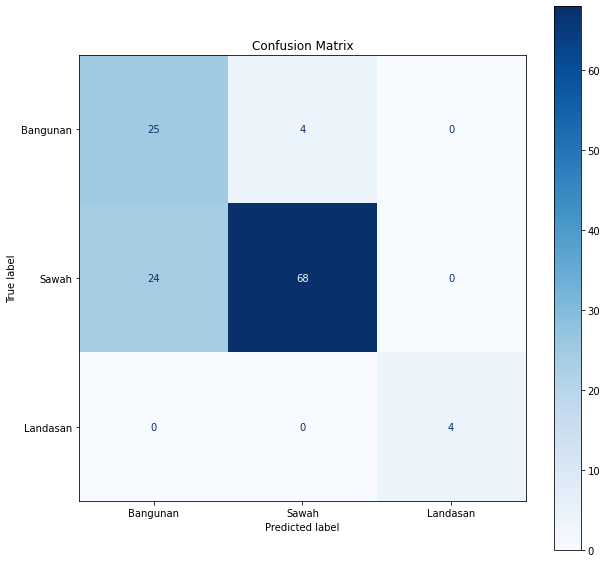

In [7]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bangunan", "Sawah", "Landasan"])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [1]:
# Data kelas
TP_bangunan, FP_bangunan, FN_bangunan = 25, 24, 4
TP_sawah, FP_sawah, FN_sawah = 68, 4, 24
TP_landasan, FP_landasan, FN_landasan = 4, 0, 0

# Precision per kelas
precision_bangunan = TP_bangunan / (TP_bangunan + FP_bangunan)
precision_sawah = TP_sawah / (TP_sawah + FP_sawah)
precision_landasan = TP_landasan / (TP_landasan + FP_landasan)

# Average Precision (AP) per kelas
ap_bangunan = precision_bangunan
ap_sawah = precision_sawah
ap_landasan = precision_landasan

# mean Average Precision (mAP)
map_score = (ap_bangunan + ap_sawah + ap_landasan) / 3

# Recall per kelas
recall_bangunan = TP_bangunan / (TP_bangunan + FN_bangunan)
recall_sawah = TP_sawah / (TP_sawah + FN_sawah)
recall_landasan = TP_landasan / (TP_landasan + FN_landasan)

# F1 Score per kelas
f1_score_bangunan = 2 * (precision_bangunan * recall_bangunan) / (precision_bangunan + recall_bangunan)
f1_score_sawah = 2 * (precision_sawah * recall_sawah) / (precision_sawah + recall_sawah)
f1_score_landasan = 2 * (precision_landasan * recall_landasan) / (precision_landasan + recall_landasan)

# Total TP, FP, FN
total_TP = TP_bangunan + TP_sawah + TP_landasan
total_FP = FP_bangunan + FP_sawah + FP_landasan
total_FN = FN_bangunan + FN_sawah + FN_landasan
total_pixels = total_TP + total_FP + total_FN

# Akurasi keseluruhan
accuracy = total_TP / total_pixels

# Precision keseluruhan
precision_overall = total_TP / (total_TP + total_FP)

# Recall keseluruhan
recall_overall = total_TP / (total_TP + total_FN)

# F1 Score keseluruhan
f1_score_overall = 2 * (precision_overall * recall_overall) / (precision_overall + recall_overall)

# Average Precision (AP) per kelas
ap_bangunan = precision_bangunan
ap_sawah = precision_sawah
ap_landasan = precision_landasan

# mean Average Precision (mAP)
map_score = (ap_bangunan + ap_sawah + ap_landasan) / 3

# Akurasi per kelas (tanpa TN)
accuracy_bangunan = TP_bangunan / (TP_bangunan + FP_bangunan + FN_bangunan)
accuracy_sawah = TP_sawah / (TP_sawah + FP_sawah + FN_sawah)
accuracy_landasan = TP_landasan / (TP_landasan + FP_landasan + FN_landasan)

# Print hasil
print(f"Presisi Bangunan: {precision_bangunan:.4f}")
print(f"Recall Bangunan: {recall_bangunan:.4f}")
print(f"F1 Score Bangunan: {f1_score_bangunan:.4f}")
print(f"Akurasi Bangunan: {accuracy_bangunan:.4f}")

print(f"Presisi Sawah: {precision_sawah:.4f}")
print(f"Recall Sawah: {recall_sawah:.4f}")
print(f"F1 Score Sawah: {f1_score_sawah:.4f}")
print(f"Akurasi Sawah: {accuracy_sawah:.4f}")

print(f"Presisi Landasan: {precision_landasan:.4f}")
print(f"Recall Landasan: {recall_landasan:.4f}")
print(f"F1 Score Landasan: {f1_score_landasan:.4f}")
print(f"Akurasi Landasan: {accuracy_landasan:.4f}")

print(f"Total Pixels: {total_pixels}")
print(f"Akurasi Keseluruhan: {accuracy:.4f}")
print(f"Precision Keseluruhan: {precision_overall:.4f}")
print(f"Recall Keseluruhan: {recall_overall:.4f}")
print(f"F1 Score Keseluruhan: {f1_score_overall:.4f}")
print(f"mAP: {map_score:.4f}")


Presisi Bangunan: 0.5102
Recall Bangunan: 0.8621
F1 Score Bangunan: 0.6410
Akurasi Bangunan: 0.4717
Presisi Sawah: 0.9444
Recall Sawah: 0.7391
F1 Score Sawah: 0.8293
Akurasi Sawah: 0.7083
Presisi Landasan: 1.0000
Recall Landasan: 1.0000
F1 Score Landasan: 1.0000
Akurasi Landasan: 1.0000
Total Pixels: 153
Akurasi Keseluruhan: 0.6340
Precision Keseluruhan: 0.7760
Recall Keseluruhan: 0.7760
F1 Score Keseluruhan: 0.7760
mAP: 0.8182
